# Instructor training for hold task

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch

from disp import set_plot, colors, get_ordered_colors

print('Torch version:', torch.__version__)
print('Cuda available:', torch.cuda.is_available())

device = 'cuda' if  torch.cuda.is_available() else 'cpu'
print('Device:', device)  # tested on cpu and cuda

Torch version: 1.12.1
Cuda available: False
Device: cpu


## Model params

In [2]:
torch.manual_seed(1337)

# model params
D = 2
N = 2000
TAU = .01
G = 100
DT = .001

J_psi = G*torch.randn((N, D), device=device)
B = torch.eye(D, device=device)
C = torch.eye(D, device=device)

def get_z(x):
    return 1*x

def psi_fn(z):
    return (1+torch.tanh(J_psi@z))*np.sqrt(2/N)

def eval_F(x, w_T, u):
    z = get_z(x)
    psi = psi_fn(z).reshape((N, 1))
    return (1/TAU)*(-x + C@w_T@psi + B@u)
    
def advance(x, z, w_T, u, L_nz, ml):
    x_next = x+DT*eval_F(x, w_T, u)
    z_next = get_z(x_next)
    psi_next = psi_fn(z_next)
    
    L = L_nz*ml
    w_T_next = w_T + DT*L@psi_next.T
    return x_next, w_T_next

In [3]:
# smln params
T = 1.1

LR = 2500
NEPOCH = 100
NROUND = 8

X_1_TARGS = torch.tensor([-1., 1.], device=device)

# initial conditions
x_0 = torch.tensor([[X_1_TARGS[1], 1.]], device=device).T
w_T_hat_0 = torch.zeros((D, N), device=device)

# inputs
T_U_STIMS = [DT, T/2+DT]

# loss eval
# DELAY = .06
DELAY = .5
T_LOSSS = [T_U_STIM + DELAY for T_U_STIM in T_U_STIMS]

# non-zero instructive signals
DELAY_LS = [DT, .5*TAU, TAU, 2*TAU, 5*TAU, 15*TAU, 40*TAU]

# plotting params
RX = np.linspace(-2, 2, 100)
T_W_PLOTS = [0.] + [T_U_STIM for T_U_STIM in T_U_STIMS]

In [4]:
# get integer time idxs
IT = int(round(T/DT))
t = np.arange(IT)*DT

IT_U_STIMS = [int(round(T_U/DT)) for T_U in T_U_STIMS]

IT_LOSSS = [int(round(T_LOSS/DT)) for T_LOSS in T_LOSSS]
IT_W_PLOTS = [int(round(T_W_PLOT/DT)) for T_W_PLOT in T_W_PLOTS]

# make inputs
us = torch.zeros((IT, D), device=device)
us[:, 1] = 1.
us[IT_U_STIMS[0], 0] = .02/DT*X_1_TARGS[0]
us[IT_U_STIMS[1], 0] = .02/DT*X_1_TARGS[1]

In [5]:
# specify loss
MLOSS = torch.zeros((IT, D), device=device)  # mask for loss
MLOSS[IT_LOSSS, 0] = 1

TARGS = torch.zeros((IT, D), device=device)
TARGS[MLOSS > 0] = X_1_TARGS

def loss_fn(zs):
    return torch.mean(((zs - TARGS)**2)[MLOSS>0])

Loop over training rounds

DELAY_L = 0.001
Round 0...
Round 1...
Round 2...
Round 3...
Round 4...
Round 5...
Round 6...
Round 7...
tensor(7.2790e-09)
DELAY_L = 0.005
Round 0...
Round 1...
Round 2...
Round 3...
Round 4...
Round 5...
Round 6...
Round 7...
tensor(4.1193e-07)
DELAY_L = 0.01
Round 0...
Round 1...
Round 2...
Round 3...
Round 4...
Round 5...
Round 6...
Round 7...
tensor(0.0003)
DELAY_L = 0.02
Round 0...
Round 1...
Round 2...
Round 3...
Round 4...
Round 5...
Round 6...
Round 7...
tensor(1.1949)
DELAY_L = 0.05
Round 0...
Round 1...
Round 2...
Round 3...
Round 4...
Round 5...
Round 6...
Round 7...
tensor(1.1937)
DELAY_L = 0.15
Round 0...
Round 1...
Round 2...
Round 3...
Round 4...
Round 5...
Round 6...
Round 7...
tensor(1.1940)
DELAY_L = 0.4
Round 0...
Round 1...
Round 2...
Round 3...
Round 4...
Round 5...
Round 6...
Round 7...
tensor(1.1940)


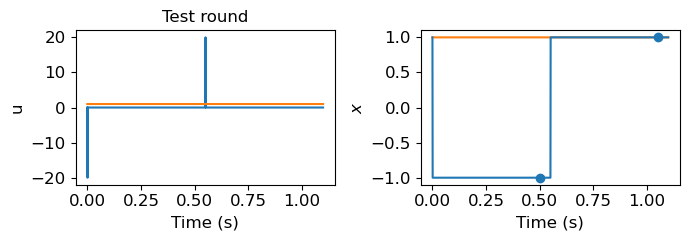

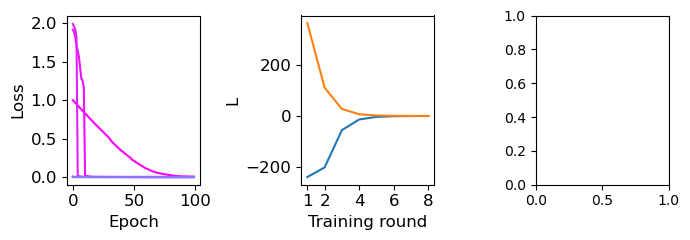

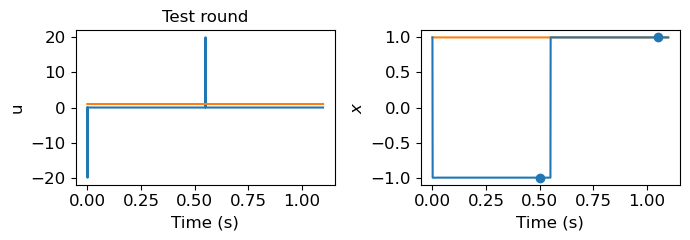

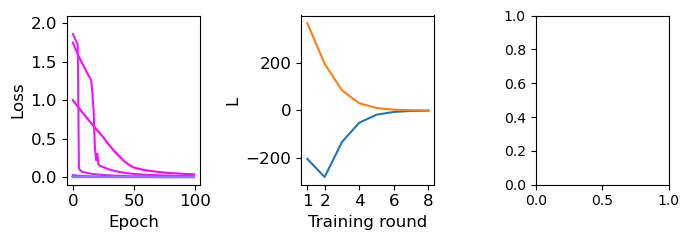

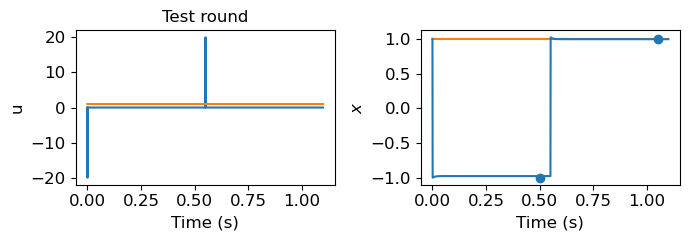

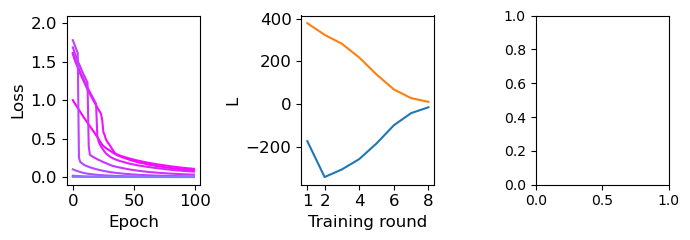

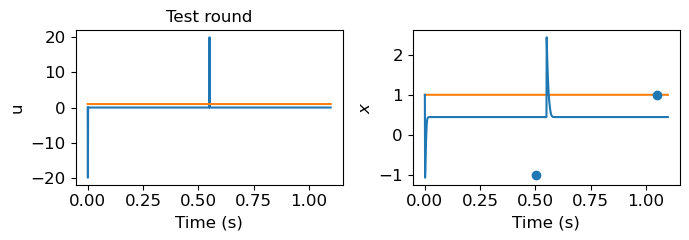

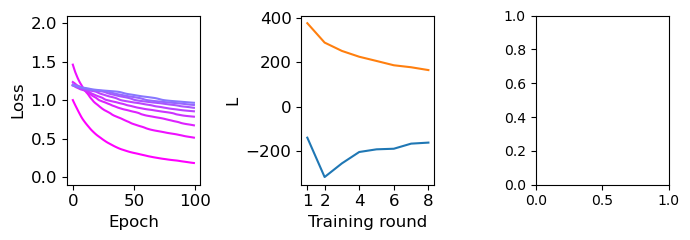

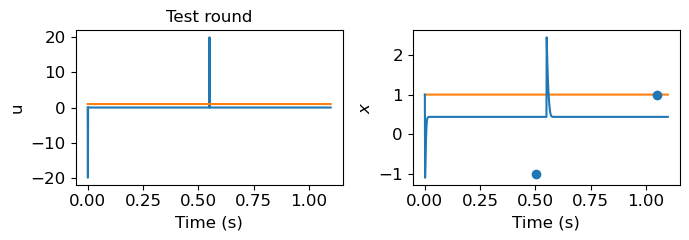

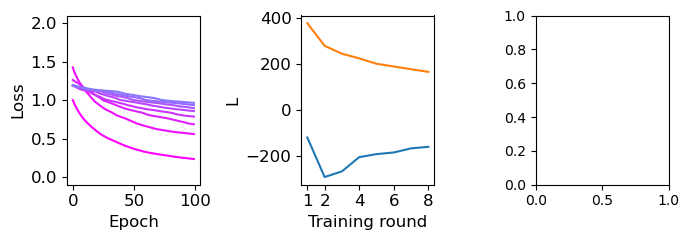

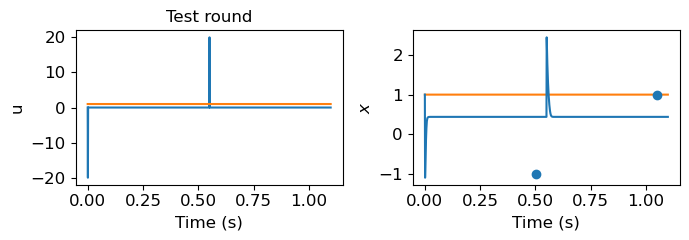

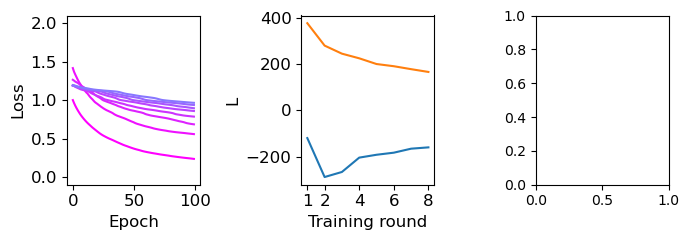

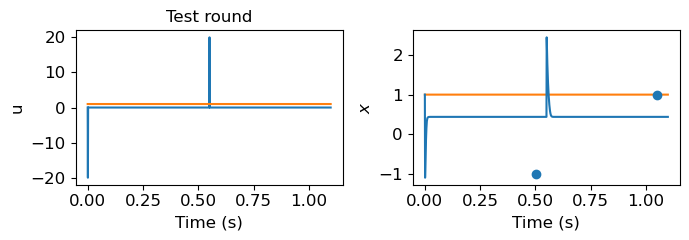

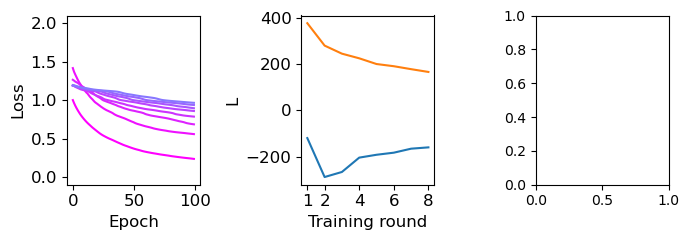

In [6]:
loss_tests = []

for DELAY_L in DELAY_LS:
    print('DELAY_L =', DELAY_L)
    # set instructive signal times
    T_L_NZS = [T_U_STIM+DELAY_L for T_U_STIM in T_U_STIMS]
    IT_L_NZS = [int(round(T_L_NZ/DT)) for T_L_NZ in T_L_NZS]
    
    # mask for nonzero learning signals
    ML = torch.zeros((IT, D), device=device)
    ML[IT_L_NZS, 0] = 1
    
    SHOW_PLOTS = False
    
    losses_all = []
    L_nz_save_all = []

    # reinitialize weights
    w_T_hat_0 = torch.zeros((D, N), device=device)
    
    for cround in range(NROUND):
        sys.stdout.write(f'Round {cround}...\n')
        # simulation/training
        L_nz = ML.clone().detach()*0  # initialize instructor signal
        L_nz.requires_grad = True
        
        losses = []
        L_nz_save = []
        z_hats_save = []
        
        for epoch in range(NEPOCH):
        
            x_hats = [x_0.clone()]
            z_hats = [get_z(x_hats[0])]
            w_T_hats = [w_T_hat_0.clone()]
        
            for ct in range(1, IT):
                x_hat_next, w_T_hat_next = advance(x_hats[-1], z_hats[-1], w_T_hats[-1], us[[ct], :].T, L_nz[[ct], :].T, ML[[ct], :].T)
                z_hat_next = get_z(x_hat_next)
        
                x_hats.append(x_hat_next)
                z_hats.append(z_hat_next)
                w_T_hats.append(w_T_hat_next)
        
            x_hats_cc = torch.cat(x_hats, dim=1).T
            z_hats_cc = torch.cat(z_hats, dim=1).T
            w_T_hats_stack = torch.stack(w_T_hats)
        
            loss = loss_fn(z_hats_cc)
            loss.backward()
        
            with torch.no_grad():
                L_nz -= LR*L_nz.grad
                L_nz.grad.zero_()
        
            losses.append(loss.item())
        
            if epoch == 0 or ((epoch + 1)%50 == 0) or (epoch+1 == NEPOCH):
                z_hats_save.append(z_hats_cc.clone().detach().numpy())
                L_nz_save.append(L_nz.clone().detach().numpy())
        
        w_T_hat_0 = w_T_hats[-1].detach()
    
        losses_all.append(torch.tensor(losses).detach())
        L_nz_save_all.append(L_nz_save[-1].copy())
        
        # plots
        if SHOW_PLOTS:
            fig, axs = plt.subplots(1, 4, figsize=(12, 2.5), tight_layout=True)
            
            axs[0].plot(range(NEPOCH), losses)
            set_plot(axs[0], x_label='Epoch', y_label='Loss', title=f'Round {cround}')
            
            axs[1].plot(t, us)
            set_plot(axs[1], x_label='Time (s)', y_label='u', title=f'Round {cround}')
            
            for d, c in zip(range(D), colors):
                axs[2].plot(t, z_hats_save[0][:, d], c=c, lw=1, ls='--')
                axs[2].plot(t, z_hats_save[-1][:, d], c=c)
                
            for itmloss, cmloss in torch.nonzero(MLOSS):
                axs[2].scatter(itmloss*DT, TARGS[itmloss, cmloss], c='k')
                
            set_plot(axs[2], x_label='Time (s)', y_label='$z$')
            
            axs[3].plot(t, L_nz.detach(), c=c, lw=1)
            set_plot(axs[3], x_label='Time (s)', y_label=r'$L_{nz}$')
            
            # plot weights and flow fields
            fig, axs = plt.subplots(2, 3, figsize=(12, 5), tight_layout=True)
            axs = axs.flatten()
            
            # weights
            for T_W_PLOT, IT_W_PLOT, ax in zip(T_W_PLOTS, IT_W_PLOTS, axs[:3]):
                w_T_hat_temp = w_T_hats[IT_W_PLOT].detach().numpy()
                ax.plot(w_T_hat_temp.T, lw=.1)
                set_plot(ax, x_label='Neuron', y_label='Weight', title=f'T = {T_W_PLOT}s')
            
            # flow fields
            for T_W_PLOT, IT_W_PLOT, ax in zip(T_W_PLOTS, IT_W_PLOTS, axs[3:]):
                w_T_hat_temp = w_T_hats[IT_W_PLOT].detach().numpy()
                F_temp = torch.stack([eval_F(torch.tensor([[x_, 1.]], dtype=torch.float).T, w_T_hat_temp, torch.tensor([[0, 1.]]).T)[0] for x_ in RX])
                ax.plot(RX, F_temp)
                ax.grid()
                set_plot(ax, x_label=r'$x_1$', y_label='dx/dt_1')
    
    # test round
    x_hats = [x_0.clone()]
    z_hats = [get_z(x_hats[0])]
    
    for ct in range(1, IT):
        x_hat_next, w_T_hat_next = advance(x_hats[-1], z_hats[-1], w_T_hats[-1], us[[ct], :].T, 0*L_nz[[ct], :].T, ML[[ct], :].T)
        z_hat_next = get_z(x_hat_next)
    
        x_hats.append(x_hat_next)
        z_hats.append(z_hat_next)
    
    x_hats_cc = torch.cat(x_hats, dim=1).T.detach()
    z_hats_cc = torch.cat(z_hats, dim=1).T.detach()

    loss_test = loss_fn(z_hats_cc)
    print(loss_test)

    loss_tests.append(loss_test)
    
    fig, axs = plt.subplots(1, 2, figsize=(7, 2.5), tight_layout=True)
    
    axs[0].plot(t, us)
    set_plot(axs[0], x_label='Time (s)', y_label='u', title=f'Test round')
    
    for d, c in zip(range(D), colors):
        axs[1].plot(t, z_hats_cc[:, d], c=c, zorder=-d)
        
    for itmloss, cmloss in torch.nonzero(MLOSS):
        axs[1].scatter(itmloss*DT, TARGS[itmloss, cmloss], c=colors[0], zorder=1)
        
    set_plot(axs[1], x_label='Time (s)', y_label='$x$')
    # fig.savefig('ms/5_instr_training_hold_demo.svg')
    
    fig, axs = plt.subplots(1, 3, figsize=(7, 2.5), tight_layout=True)
    
    # plot loss trajectory for each round
    cs = get_ordered_colors('cool', NROUND*2)[::-1]
    for losses, c in zip(losses_all, cs):
        axs[0].plot(range(NEPOCH), losses, color=c)
    set_plot(axs[0], y_lim=(-.1, 2.1), x_label='Epoch', y_label='Loss')
    
    # plot size of instructive signals vs round
    L_nz_0 = [L_nz_save[IT_L_NZS[0], 0] for L_nz_save in L_nz_save_all]
    L_nz_1 = [L_nz_save[IT_L_NZS[1], 0] for L_nz_save in L_nz_save_all]
    
    axs[1].plot(1+np.arange(NROUND), L_nz_0)
    axs[1].plot(1+np.arange(NROUND), L_nz_1)
    set_plot(axs[1], x_ticks=[1, 2, 4, 6, 8], x_label='Training round', y_label='L')
    
    # fig.savefig('ms/5_instr_training_hold_loss.svg')

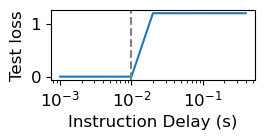

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(2.75, 1.5), tight_layout=True)
ax.semilogx(DELAY_LS, loss_tests)
ax.axvline(TAU, color='gray', ls='--')
set_plot(ax, x_label='Instruction Delay (s)', y_label='Test loss')
fig.savefig('ms/5_instr_train_hold_task_test_loss_vs_delay_l.svg')

In [9]:
np.save('data/instr_training_hold_task_test_loss_vs_delay_l.npy', np.array([{'DELAY_LS': DELAY_LS, 'loss_tests': loss_tests, 'TAU': TAU}]))

[0, 0.005, 0.01, 0.4]